# Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов
### Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей
    
### Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

# Описание данных
### Таблица users (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

### Таблица calls (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

### Таблица messages (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

### Таблица internet (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

### Таблица tariffs (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy import stats as st
import seaborn as sns

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

for i in [calls, internet, messages, tariffs, users]:
    print(i.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None

<class 'pandas.core.fram

Привести данные к datetime:
1. call_date
2. session_date
3. message_date
4. reg_date, churn_date

Округлить:
1. duration
2. mb_used

## Подготовьте данные

In [2]:
#приводим данные к нужным типам
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

#округляем данные
calls['duration'] = calls['duration'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

#заполнять пустые значения не считаю нужным, так как данных не так много и "среднее" или "нули" могут сильно повлиять на конечные выводы.

In [3]:
#поиск ошибок
for i in [calls, internet, messages, tariffs, users]:
    display(i.describe())
    display(i.head())

,duration,user_id
count,202607.000000,202607.000000
mean,7.158198,1253.940619
std,5.959173,144.722751
min,0.000000,1000.000000
25%,2.000000,1126.000000
50%,6.000000,1260.000000
75%,11.000000,1379.000000
max,38.000000,1499.000000


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.622098,1252.099842
std,43127.054745,278.387019,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,139.000000,1130.000000
50%,74697.500000,349.000000,1251.000000
75%,112046.250000,560.000000,1380.000000
max,149395.000000,1725.000000,1499.000000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,113.0,2018-11-25,1000
1,1,1000_1,1053.0,2018-09-07,1000
2,2,1000_2,1198.0,2018-06-25,1000
3,3,1000_3,551.0,2018-08-22,1000
4,4,1000_4,303.0,2018-09-24,1000


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Ошибок в данных не обнаружено. На данном этапе данные кажутся реалистичными.

In [4]:
# сводная таблица по звонкам
calls['month'] = calls['call_date'].dt.month
calls_grouped = calls.pivot_table(values='duration', index=['user_id', 'month'], aggfunc=['count','sum'])
calls_grouped.columns = ['calls', 'duration']


messages['month'] = messages['message_date'].dt.month
messages_grouped = messages.pivot_table(values='message_date', index=['user_id', 'month'], aggfunc='count')
messages_grouped.columns = ['message_sent']


internet['month'] = internet['session_date'].dt.month
internet_grouped = internet.pivot_table(values='mb_used', index=['user_id', 'month'], aggfunc='sum')
internet_grouped.columns = ['mb_used']

data = calls_grouped.merge(messages_grouped, on=['user_id', 'month'], how='outer')
data = data.merge(internet_grouped, on=['user_id', 'month'], how='outer')

for i in data.index:
    data.loc[i, 'tariff'] = users.loc[i[0]-1000, 'tariff']

    
data['calls'] = data['calls'].fillna(0)
data['duration'] = data['duration'].fillna(0)
data['message_sent'] = data['message_sent'].fillna(0)
data['mb_used'] = data['mb_used'].fillna(0)

data.head()

#заполню все пустые значения нулем, так как отсутсвтие данных сильно исказит итоговые результаты

calls  duration  message_sent  mb_used tariff
user_id month                                               
1000    5       22.0     159.0          22.0   2256.0  ultra
        6       43.0     172.0          60.0  23257.0  ultra
        7       47.0     340.0          75.0  14016.0  ultra
        8       52.0     408.0          81.0  14070.0  ultra
        9       58.0     466.0          57.0  14581.0  ultra

In [5]:
def revenue(row):
    duration = row['duration']
    message = row['message_sent']
    internet = row['mb_used']
    tariff = row['tariff']
    calls = row['calls']
    
    if tariff == 'smart':
        duration_revenue = (duration - tariffs.loc[0, 'minutes_included']) * tariffs.loc[0, 'rub_per_minute']
        internet_revenue = ((internet - tariffs.loc[0, 'mb_per_month_included']) / 1024) * tariffs.loc[0, 'rub_per_gb']
        message_revenue = (message - tariffs.loc[0, 'messages_included']) * tariffs.loc[0, 'rub_per_message']
        
        if duration_revenue < 0:
            duration_revenue = 0
        if internet_revenue < 0:
            internet_revenue = 0
        if message_revenue < 0:
            message_revenue = 0
            
        return (duration_revenue + internet_revenue + message_revenue + message_revenue + tariffs.loc[0, 'rub_monthly_fee'])
    else:
        duration_revenue = (duration - tariffs.loc[1, 'minutes_included']) * tariffs.loc[1, 'rub_per_minute']
        internet_revenue = ((internet - tariffs.loc[1, 'mb_per_month_included']) / 1024) * tariffs.loc[1, 'rub_per_gb']
        message_revenue = (message - tariffs.loc[1, 'messages_included']) * tariffs.loc[1, 'rub_per_message']
        
        if duration_revenue < 0:
            duration_revenue = 0
        if internet_revenue < 0:
            internet_revenue = 0
        if message_revenue < 0:
            message_revenue = 0
            
        return (duration_revenue + internet_revenue + message_revenue + message_revenue + tariffs.loc[1, 'rub_monthly_fee'])
      
data['revenue'] = data.apply(revenue, axis=1)

## Проанализируйте данные

In [6]:
#Опишите поведение клиентов оператора, исходя из выборки. 
#Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
#Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

mean_data_per_user = data.pivot_table(index='user_id', values=['duration', 'message_sent', 'mb_used'], aggfunc='mean')

for i in users['user_id']:
    mean_data_per_user.loc[i, 'tariff'] = users.loc[i-1000, 'tariff']

In [7]:
general_data = mean_data_per_user.pivot_table(index='tariff', values=['duration', 'mb_used', 'message_sent'], aggfunc=['mean', 'var','std'])
general_data

mean                                      var                \
          duration       mb_used message_sent      duration       mb_used   
tariff                                                                      
smart   419.634803  16201.387920    32.352078  21034.148607  1.284248e+07   
ultra   527.821819  19592.839001    54.030743  79403.551850  6.920167e+07   

                            std                            
       message_sent    duration      mb_used message_sent  
tariff                                                     
smart    702.909910  145.031543  3583.640810    26.512448  
ultra   2149.828793  281.786359  8318.753942    46.366246

In [15]:
### Код ревьювера ###

general_data.T.astype('int')

tariff                smart     ultra
mean duration           419       527
     mb_used          16201     19592
     message_sent        32        54
var  duration         21034     79403
     mb_used       12842481  69201667
     message_sent       702      2149
std  duration           145       281
     mb_used           3583      8318
     message_sent        26        46

Выводы:
1. Видим, что среднее количество использованных ГБ в тарифе смарт превышает возможности тарифа
2. Дисперсия тарифа ультра значительно выше, чем у тарифа смарт
3. Среднее отклонение у тарифа ультра также выше, чем у тарифа смарт

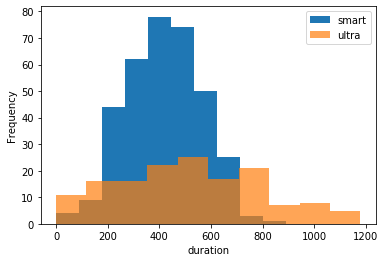

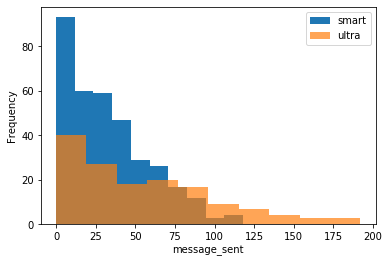

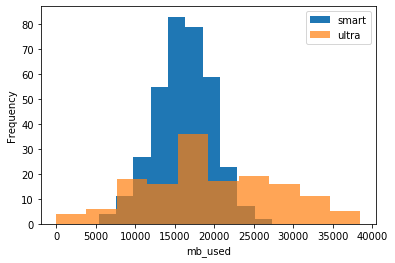

In [8]:
smart_data = mean_data_per_user[mean_data_per_user['tariff'] == 'smart']
ultra_data = mean_data_per_user[mean_data_per_user['tariff'] == 'ultra']

for i in ['duration', 'message_sent', 'mb_used']:
    ax = smart_data.plot(kind='hist', y=i, label='smart')
    plt.xlabel(i)
    ultra_data.plot(kind='hist', y=i, ax=ax, alpha=0.7, label='ultra')

Выводы: Видим, что у тарифа ультра данные разбросаны гораздо сильнее, в то время как у тарифа ультра все сжато в определенном диапазоне и видимо присутствует зависимость от возможностей тарифа. Также данные по этому графику подтверждает стандартное отклонение обоих тарифов. 

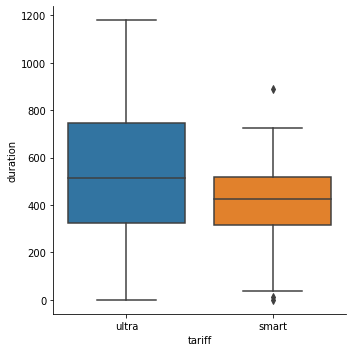

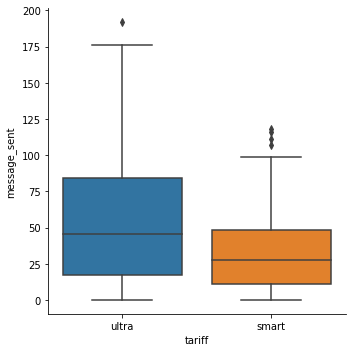

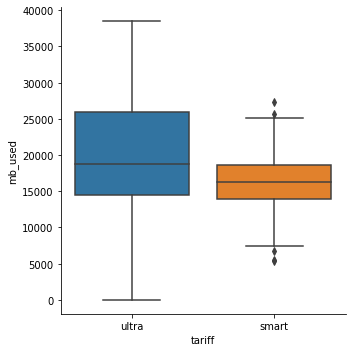

In [9]:
for i in ['duration', 'message_sent', 'mb_used']:
    sns.catplot(data=mean_data_per_user, x='tariff', y=i, kind='box')

Выводы:
1. Видим по диаграмме распределения, что большинство данных тарифа смарт не переваливают за 500 минут разговорного времени. Это говорит о том, что пользователи пытаются уложиться в условия тарифа и не хотят переплачивать лишние деньги. В то время мы также видим, что у тарифа ультра нормальные значения заканчиваются 1200 минутами разговора. Это говорит нам о том, что пользователи впринципе крайне редко полностью исчерпывают разговорные минуты в тарифе ультра.
2. По сообщениям видим аналогичную картину, что пользователи смарт тарифа стараются уложиться в тариф, в то время как нормальные значения тарифа ультра заканчиваются 175 сообщениями в месяц (из 1000 сообщений возможных в месяц).
3. В использовании интернет трафика мы видим иную картину. БОльшая часть пользователей превышают возможности своего тарифа. Однако тем не менее, большая часть пользователей тарифа ультра всё же укладывается в 30 ГБ возможного трафика, в то время как большинство смарт пользователей превышают возможности своего тарифа на 3-4 ГБ.


## Проверьте гипотезы

H0: средняя выручка пользователей тарифа «Ультра» ==  средней выручке пользователей тарифа «Смарт»

H1: средняя выручка пользователей тарифа «Ультра» !=  средней выручке пользователей тарифа «Смарт»

alpha == 0.05

In [10]:
smart_mean_revenue = data.query('tariff =="smart"')['revenue']
ultra_mean_revenue = data.query('tariff =="ultra"')['revenue']

smart_mean_revenue.describe()

alpha = .05

results = st.ttest_ind(smart_mean_revenue, ultra_mean_revenue, equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  5.384627268770379e-283
Отвергаем нулевую гипотезу


In [11]:
revenue_tariff = data.pivot_table(index='tariff', values='revenue', aggfunc='mean')
revenue_tariff

,revenue
tariff,
smart,1250.749197
ultra,2060.529971


Выводы: Действительно, нулевая гипотеза не подтверждается. Средняя выручка тарифа смарт значительно ниже.

H0: средняя выручка пользователей из Москвы == выручке пользователей из других регионов

H1: средняя выручка пользователей из Москвы != выручке пользователей из других регионов

alpha = 0.05

In [12]:
for i in data.index:
    data.loc[i, 'city'] = users.loc[i[0]-1000, 'city']

moscow_mean_revenue = data.query('city == "Москва"')['revenue']
cities_mean_revenue = data.query('city != "Москва"')['revenue']

results2 = st.ttest_ind(moscow_mean_revenue, cities_mean_revenue)

print('p-значение', results2.pvalue)

if results2.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение 0.5782562496686401
Не получилось отвергнуть нулевую гипотезу


In [13]:
def region(city):
    if city == 'Москва':
        return 'Москва'
    else:
        return 'Другой город'
    
data['region'] = data['city'].apply(region)
region_data = data.pivot_table(index='region', values='revenue', aggfunc='mean')
region_data

,revenue
region,
Другой город,1495.194345
Москва,1514.813587


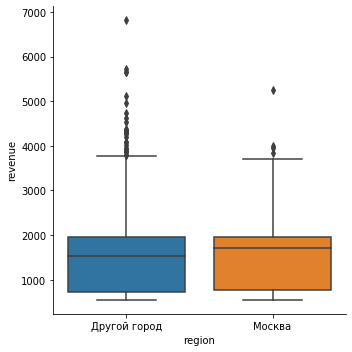

In [14]:
sns.catplot(data=data, x='region', y='revenue', kind='box')

Выводы: На графике видно, что выручка Москвы и других городов практически не отличаются. Различия между данными получились статистически не значимы (значение p, меньше альфы). 

## Проверьте гипотезы

1. Доходы от тарифа ультра значительно выше: 1250 рублей за смарт и 2060 рублей за ультра
2. Средняя выручка Москвы и других городов практически не отличаются
3. В среднем, пользователи тарифа смарт переплачивают 700 рублей ежемесячно (помимо стоимости тарифа), в то время как пользователи тарифа ультра переплачивают лишь 110 рублей